In [53]:
import numpy as np
from numpy.linalg import norm, solve
from icosphere import icosphere
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

class FEMSphereSolver:
    def __init__(self, radius=1, epsilon=1e-8):
        self.radius = radius
        self.epsilon = epsilon
        self.vertices = None
        self.faces = None
        self.S = None
        self.M = None

    def generate_mesh(self, nu):
        self.vertices, self.faces = icosphere(nu)
        return self.vertices, self.faces

    ### Define local stiff and local math
    def compute_local_stiffness(self, r1, r2, r3):
        E1 = r2 - r3
        E2 = r3 - r1
        E3 = r1 - r2
        cross = np.cross(E1, E2)
        A = 0.5*norm(cross)
        S_loc = np.array(([np.dot(E1, E1), np.dot(E1, E2), np.dot(E1, E3)], 
                      [np.dot(E2, E1), np.dot(E2, E2), np.dot(E2, E3)], 
                      [np.dot(E3, E2), np.dot(E3, E2), np.dot(E3, E3)]))
        S_k = (1/(4*A))*S_loc
        return S_k

    def compute_local_mass(self, r1, r2, r3):
        E1 = r2 - r3
        E2 = r3 - r1
        E3 = r1 - r2
        crossin = np.cross(E1, E2)
        A = 0.5*norm(crossin)
        M_k = (A/12)*np.array(([2, 1, 1], [1, 2, 1], [1, 1, 2]))
        return M_k

    def compute_global_matrices(self):
        # Placeholder for your implementation
        Nv = self.vertices.shape[0]
        self.S = np.zeros((Nv, Nv))
        self.M = np.zeros((Nv, Nv))

        for tri in self.faces:
            k1, k2, k3 = tri
            r1, r2, r3 = self.vertices[k1], self.vertices[k2], self.vertices[k3]

            local_stiffness = self.compute_local_stiffness(r1, r2, r3)
            local_mass = self.compute_local_mass(r1, r2, r3)

            for i, vertex_i in enumerate(tri):
                for j, vertex_j in enumerate(tri):
                    self.S[vertex_i, vertex_j] += local_stiffness[i, j]
                    self.M[vertex_i, vertex_j] += local_mass[i, j]

        return self.S, self.M

    def plot_solutions(self, solution):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        x, y, z = self.vertices[:, 0], self.vertices[:, 1], self.vertices[:, 2]

    # Normalize the solution for color mapping
        solution_min, solution_max = np.min(solution), np.max(solution)
        solution_normalized = (solution - solution_min) / (solution_max - solution_min)

        cmap = plt.get_cmap('viridis')
        colors = cmap(solution_normalized)

        surf = ax.plot_trisurf(x, y, z, triangles=self.faces, cmap=cmap, linewidth=0.2, antialiased=True)
        surf.set_facecolors(colors)

        mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=solution_min, vmax=solution_max))
        mappable.set_array(solution)
        plt.colorbar(mappable, ax=ax, label='Solution Value')

        ax.set_xlabel('X axis')
        ax.set_ylabel('Y axis')
        ax.set_zlabel('Z axis')
        ax.set_title('Solution to the Heat Equation on a Sphere')
        plt.show()

# Now, the new class for the heat equation
class HeatEquationSolver(FEMSphereSolver):
    def __init__(self, kappa, time_step, total_time, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.kappa = kappa  # Thermal diffusivity
        self.time_step = time_step  # Time step for the Euler method
        self.total_time = total_time  # Total time for the simulation
        self.time = 0  # Current time
        self.U = None  # Solution array

    def set_initial_conditions(self):
        # Assume vertices are in spherical coordinates (r, theta, phi)
        # Set the initial condition for U based on the polar angle theta
        _, theta, _ = self.vertices_to_spherical(self.vertices)  # Convert Cartesian to spherical
        self.U = np.cos(theta)

    def vertices_to_spherical(self, vertices):
        # Convert Cartesian (x, y, z) to spherical coordinates (phi, theta, r)
        x, y, z = vertices[:, 0], vertices[:, 1], vertices[:, 2]
        hxy = np.hypot(x, y)
        r = np.hypot(hxy, z)
        phi = np.arctan2(y, x)
        theta = np.arctan2(z, hxy)
        return phi, theta, r

    def identify_equator_vertices(self):
        # Identify vertices at the equator, assumed to be those with z-coordinate close to zero
        self.equator_indices = np.where(np.isclose(self.vertices[:, 2], 0, atol=1e-2))[0]

    def apply_boundary_conditions(self):
        # Apply boundary conditions to the solution U
        # Set the temperature at the equator vertices to 0
        if self.equator_indices is not None:
            self.U[self.equator_indices] = 0

    def step_forward(self):
        # Perform one time step using the Euler method
        self.U = self.U + self.time_step * self.kappa * (self.S @ self.U)

    def solve(self):
        self.set_initial_conditions()
        self.identify_equator_vertices()
        A = self.M - self.time_step * self.kappa * self.S  # System matrix for the implicit time-stepping
        for _ in range(int(self.total_time / self.time_step)):
            b = self.M @ self.U  # Right-hand side for the current time step
            self.apply_boundary_conditions()
            self.U = np.linalg.solve(A, b)  

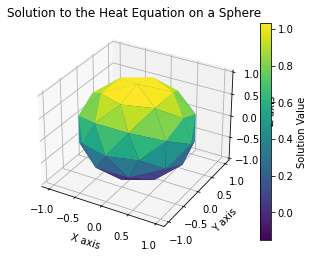

In [54]:
solver = HeatEquationSolver(kappa=1e-2, time_step=0.01, total_time=1)
solver.generate_mesh(nu=2)  # Assuming 'nu' determines mesh refinement
solver.compute_global_matrices()
solver.solve()
a = solver.plot_solutions(solver.U)

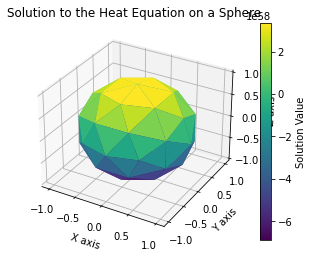

In [56]:

solver = HeatEquationSolver(kappa=10, time_step=0.01, total_time=1)
solver.generate_mesh(nu=2) 
solver.compute_global_matrices()
solver.solve()
solver.plot_solutions(solver.U)